# setup

In [1]:
run_test=True
# run_test=False
import torch,sys

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  mydrive='/content/drive/MyDrive/volrt/'
  source_path=mydrive+"git/Crossformer"
  tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
  batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*64
  import os,sys
  if not os.path.exists(source_path):
    %cd $mydrive/git
    !git clone https://github.com/jerronl/Crossformer.git
    %cd $source_path
  else:
    %cd $source_path
    !git reset --hard HEAD
    !git pull origin master
  !pip install einops #scikit-learn
  sys.path.append( source_path)
else:
  tables = [ 'volvA.csv', 'volvG.csv', ]
  mydrive= 'E:/mydoc/git/trade/analyics/'
  batch_size=32
%cd $mydrive


import argparse
import torch

from cross_exp.exp_crossformer import Exp_crossformer
from utils.tools import string_split


parser = argparse.ArgumentParser(description="CrossFormer")

parser.add_argument("--data", type=str, default="vols", help="data")
parser.add_argument(
    "--root_path", type=str, default=mydrive, help="root path of the data file"
)
parser.add_argument("--data_path", type=list, default=tables, help="data file")
parser.add_argument(
    "--data_split",
    type=str,
    default="0.7,0.1,0.2",
    help="train/val/test split, can be ratio or number",
)
parser.add_argument(
    "--checkpoints",
    type=str,
    default="./checkpoints/",
    help="location to store model checkpoints",
)

parser.add_argument("--in_len", type=int, default=20, help="input MTS length (T)")
parser.add_argument("--out_len", type=int, default=1, help="output MTS length (\tau)")
parser.add_argument("--seg_len", type=int, default=5, help="segment length (L_seg)")
parser.add_argument(
    "--win_size", type=int, default=2, help="window size for segment merge"
)
parser.add_argument(
    "--factor",
    type=int,
    default=10,
    help="num of routers in Cross-Dimension Stage of TSA (c)",
)

parser.add_argument(
    "--d_model", type=int, default=256, help="dimension of hidden states (d_model)"
)
parser.add_argument(
    "--d_ff", type=int, default=512, help="dimension of MLP in transformer"
)
parser.add_argument("--n_heads", type=int, default=4, help="num of heads")
parser.add_argument("--e_layers", type=int, default=3, help="num of encoder layers (N)")
parser.add_argument("--dropout", type=float, default=0.2, help="dropout")

parser.add_argument(
    "--baseline",
    action="store_true",
    help="whether to use mean of past series as baseline for prediction",
    default=False,
)

parser.add_argument(
    "--num_workers", type=int, default=0, help="data loader num workers"
)
parser.add_argument(
    "--batch_size", type=int, default=32, help="batch size of train input data"
)
parser.add_argument("--train_epochs", type=int, default=20, help="train epochs")
parser.add_argument("--patience", type=int, default=3, help="early stopping patience")
parser.add_argument(
    "--learning_rate", type=float, default=1e-4, help="optimizer initial learning rate"
)
parser.add_argument("--lradj", type=str, default="type1", help="adjust learning rate")
parser.add_argument("--itr", type=int, default=5, help="experiments times")

parser.add_argument(
    "--save_pred",
    action="store_true",
    help="whether to save the predicted future MTS",
    default=False,
)

parser.add_argument("--use_gpu", type=bool, default=True, help="use gpu")
parser.add_argument("--resume", type=bool, default=True, help="resume")
parser.add_argument("--query", type=str, default=None, help="resume")
# parser.add_argument("--use_gpu", type=bool, default=False, help="use gpu")
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument(
    "--use_multi_gpu", action="store_true", help="use multiple gpus", default=False
)
parser.add_argument(
    "--devices", type=str, default="0,1,2,3", help="device ids of multile gpus"
)

args = parser.parse_args(args=[])

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(" ", "")
    device_ids = args.devices.split(",")
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)


def update_args(itr):
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        for k,v in data_info.items():
            args.__setattr__(k,v)
    if isinstance(args.data_split, str) :
        args.data_split = string_split(args.data_split)

    print("Args in experiment:")
    print(args)
    setting = "Crossformer_il{}_ol{}_sl{}_win{}_fa{}_dm{}_nh{}_el{}_itr{}".format(
        args.in_len,
        args.out_len,
        args.seg_len,
        args.win_size,
        args.factor,
        args.d_model,
        args.n_heads,
        args.e_layers,
        itr,
    )
    return setting
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt


def regplot(cols,figsize=(16, 16)):
  cnt=len(dep_var)-dep_var.count('_')
  figs = min(cnt, cols)
  _, axes = plt.subplots(math.ceil(cnt / figs), figs, figsize=figsize)
  j=0

  for i, name in enumerate(dep_var):
      if name!='_':
        axs = axes.flat[j] if figs > 1 else axes
        j=j+1
        left,right = 999,-999
        for ii in range(len(tables)):
          preds, trues = results[ii]
          sns.regplot(
              ax=axs,
              x=trues[:, i],
              y=preds[:, i],
              scatter_kws={"color": f"C{ii}", "alpha": 0.3},
              line_kws={"color": f"C{ii}", "alpha": 0.3},
              label=tables[ii],
          )
          mask = ~np.isnan(trues[:, i])
          if not dep_var[i][:3] in ["dtm", "pmc"]:
              left=min(left,max(np.min(trues[:, i][mask]), -5))
              right=max(right,min(np.max(trues[:, i][mask]), 5))
          else:
              left=min(left,np.min(trues[:, i][mask]))
              right=max(right,np.max(trues[:, i][mask]))
        axs.set_title(name)
        axs.set_xlim(left=left, right=right)
        axs.legend()

  plt.show()    

d:\ProgramData\miniconda3\envs\e1\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


E:\mydoc\git\trade\analyics


# train

In [ ]:
if not run_test:
    from cross_exp.exp_crossformer import Exp_crossformer
    data_parser = {
        "vols": {
            "patience":30,
            "train_epochs":500,
            'learning_rate':2e-3,
            'data_split':[0.7,0.15,0.15],
            'batch_size':batch_size*2//5,
            'e_layers':5,
            'd_model':512,
            'lradj':'type2',
            "checkpoints":"./checkpoints/",
        },
        }
    for i in range(3):
        for ii in range(3):
            # setting record of experiments
            setting = update_args(ii)

            exp = Exp_crossformer(args)  # set experiments
            print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
            exp.train(setting, "vols")

            print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
            preds, trues = exp.test(setting, 'vols', True, data_path=[tables[-1]], inverse=True)
            print(preds.shape, trues.shape)

            exp.train(setting, "prcs")
            preds, trues = exp.test(setting, 'prcs', True, data_path=[tables[-1]], inverse=True)
            print(preds.shape, trues.shape)


In [ ]:
if not run_test:        
    from google.colab import runtime
    runtime.unassign()

# test

In [ ]:
args.itr=3
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
    },
    }
dep_var=['level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(3)

In [ ]:
dep_var=['level0', '_', '_', 'level1', '_', '_', 'level2', '_', '_', 'level3', '_', '_']
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")  
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(4,(20,5))

In [ ]:
dep_var=['pmcat','close', 'hi', 'lo',]
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'prcs', True, data_path=[table], inverse=True))
  regplot(2)
  for i,result in enumerate(results):
    preds, trues = result
    preds=preds[:,-22:].argmax(1)
    sns.jointplot(x=trues[:,0] , y=preds,kind="kde",fill=True,rug=True, color=f'C{i+1}')

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=3, save_pred=False, use_gpu=True, resume=True, cutday=('#2024-02-15', '#2024-03-22'), gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0vols/crossformer.pkl 
volvA.csv 12020    #2024-02-15 15:57:57#
12020    #2024-02-15 15:57:57#
12020    #2024-02-15 15:57:57#
13252    #2024-03-21 15:58:23#
Name: date, dtype: object
test 369
mae:0.383, mse:0.459, rmse:0.667, mape:4.411, mspe:2115.521, accr

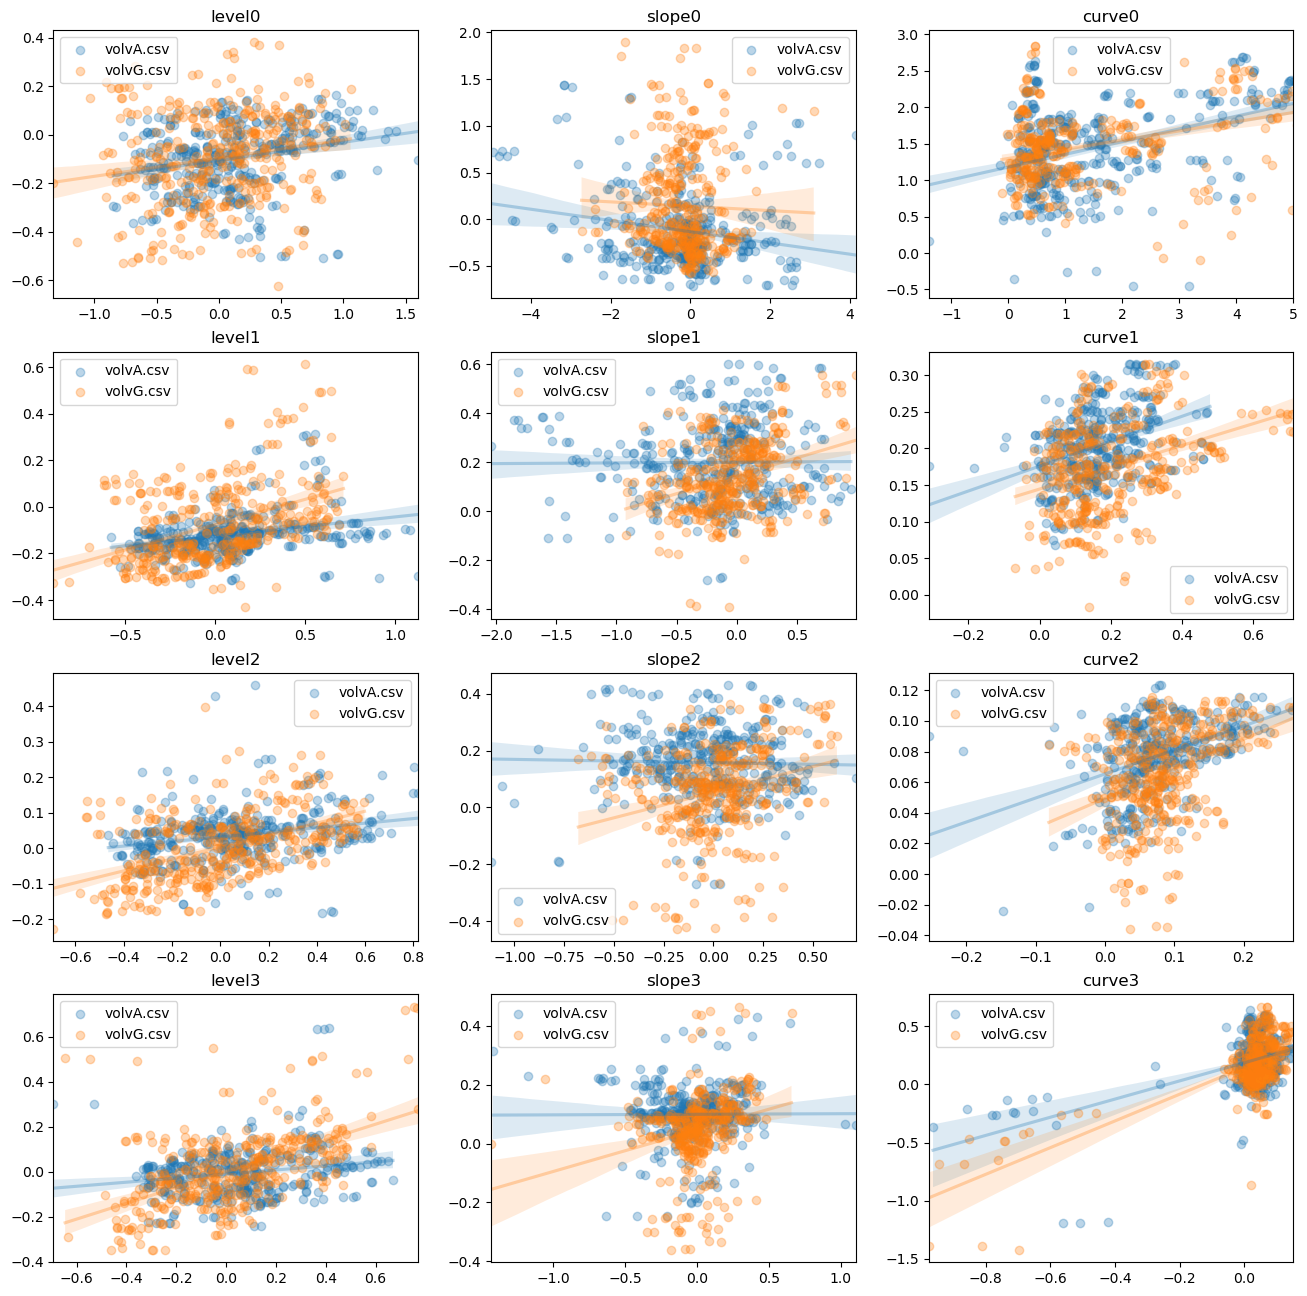

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=3, save_pred=False, use_gpu=True, resume=True, cutday=('#2024-02-15', '#2024-03-22'), gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
failed to load [Errno 2] No such file or directory: './checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr1vols/crossformer.pkl' ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr1vols/crossformer.pkl 


KeyError: 'Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr1vols'

In [20]:
from data.data_loader import DatasetMTS
from cross_exp.exp_crossformer import Exp_crossformer
args.itr=3
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,        
        "query": "date>'#2024-02-15' and date<'#2024-03-22'",
    },
    }
DatasetMTS.clear()    
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  dep_var=['level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(3)

In [2]:
from data.data_loader import DatasetMTS
from cross_exp.exp_crossformer import Exp_crossformer
tables = ['volvN.csv', ]
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,        
        "query": "date>'#2024-02-15' and date<'#2024-03-22'",
    },
    }
DatasetMTS.clear()    
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  dep_var=['level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
  results = []
  for table in tables:
      results.append(exp.test(data="vols", save_pred=True, inverse=True, run_metric=False, data_path=[table]))
  regplot(3)

In [7]:
results[0][1][:10]

array([[ 4.00810987e-01, -6.74203972e-01,  3.66615608e+00,
         3.30614997e+00,  2.96060994e-01, -3.32329992e-01,
         1.83405395e+00,  3.72840011e-02, -1.86730003e-01,
         1.27978605e+00,  3.81919996e-02, -7.77149998e-02],
       [ 4.20923008e-01, -6.08332005e-01,  3.60280591e+00,
         3.28702102e+00,  3.23944986e-01, -3.20690022e-01,
         1.81870309e+00,  6.80849995e-02, -1.69149003e-01,
         1.27016399e+00,  4.42079992e-02, -6.76670000e-02],
       [ 4.11018986e-01, -6.89459974e-01,  3.59660312e+00,
         3.23540295e+00,  3.28893005e-01, -3.60604011e-01,
         1.78992897e+00,  6.55980017e-02, -1.82615002e-01,
         1.25409499e+00,  3.27450002e-02, -8.44619996e-02],
       [ 4.48009002e-01, -6.64031000e-01,  3.51994112e+00,
         3.22034194e+00,  2.79294987e-01, -3.67298002e-01,
         1.77867107e+00,  8.06080006e-02, -1.34141997e-01,
         1.25462999e+00,  3.29470006e-02, -7.49559996e-02],
       [ 3.78950313e+00, -1.92759999e-02, -2.2498997

In [ ]:
dep_var=['level0', '_', '_', 'level1', '_', '_', 'level2', '_', '_', 'level3', '_', '_']
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")  
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(4,(20,5))

In [ ]:
dep_var=['pmcat','close', 'hi', 'lo',]
for i in range(3):
  setting=update_args(i)
  exp = Exp_crossformer(args) 
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'prcs', True, data_path=[table], inverse=True))
  regplot(2)
  for i,result in enumerate(results):
    preds, trues = result
    preds=preds[:,-22:].argmax(1)
    sns.jointplot(x=trues[:,0] , y=preds,kind="kde",fill=True,rug=True, color=f'C{i+1}')

In [ ]:
from google.colab import runtime
runtime.unassign()